In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(os.path.join(dirname))
#     # for filename in filenames:

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import copy
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

## Dataset Loading

In [3]:

# Define dataset paths
content_dir = "/kaggle/input/image-classification"
style_dir = "/kaggle/input/wikiart"

# Get image paths
content_images = glob(f"{content_dir}/**/*.jpg", recursive=True)
style_images = glob(f"{style_dir}/**/*.jpg", recursive=True)

# Sample subset (e.g., 9000 content and 1000 style images)
content_images = random.sample(content_images, min(9000, len(content_images)))
style_images = random.sample(style_images, min(1000, len(style_images)))

# Split content images
train_c, val_c = train_test_split(content_images, test_size=0.2, random_state=42)
val_c, test_c = train_test_split(val_c, test_size=0.5, random_state=42)

# Split style images
train_s, val_s = train_test_split(style_images, test_size=0.2, random_state=42)
val_s, test_s = train_test_split(val_s, test_size=0.5, random_state=42)

## Data Preprocessing

In [ ]:
image_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
class StyleTransferDataset(Dataset):
    def __init__(self, content_paths, style_paths, training=True):
        self.content_paths = content_paths
        self.style_paths = style_paths
        self.training = training

    def __len__(self):
        return len(self.content_paths)

    def __getitem__(self, idx):
        content_image = load_image(self.content_paths[idx])
        style_image = load_image(random.choice(self.style_paths))  # Random style per content
        style_threshold = get_style_threshold(self.training)

        return {
            'content': content_image,
            'style': style_image,
            'threshold': torch.tensor(style_threshold, dtype=torch.float32)
        }
        
def load_image(path):
    img = Image.open(path).convert('RGB')
    img = preprocess(img).unsqueeze(0)
    return img.to(device)

def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)
    return tensor * std + mean

def imshow(tensor, title=None):
    img = unnormalize(tensor).squeeze().detach().cpu().clamp(0, 1).permute(1, 2, 0)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
train_dataset = StyleTransferDataset(train_c, train_s, training=True)
val_dataset   = StyleTransferDataset(val_c, val_s, training=False)
test_dataset  = StyleTransferDataset(test_c, test_s, training=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Model Creation

In [6]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg19(pretrained=True).features.eval()

        self.layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content
            '28': 'conv5_1'
        }

    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layers:
                features[self.layers[name]] = x
        return features

def compute_content_loss(generated_features, content_features):
    loss = nn.functional.mse_loss(generated_features, content_features)
    return loss

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

def compute_style_loss(generated_style, target_style):
    loss = 0.0
    for layer in generated_style:
        G = gram_matrix(generated_style[layer])
        A = gram_matrix(target_style[layer])
        loss += nn.functional.mse_loss(G, A)
    return loss

def generate_stylized_image(content_img, style_img, threshold, extractor, num_steps=300, lr=0.03):
    device = content_img.device
    generated_img = content_img.clone().requires_grad_(True)

    optimizer = torch.optim.Adam([generated_img], lr=lr)
    content_features, _ = extractor(content_img)
    _, style_features = extractor(style_img)

    for _ in range(num_steps):
        gen_content, gen_style = extractor(generated_img)

        c_loss = compute_content_loss(gen_content['21'], content_features['21'])
        s_loss = compute_style_loss(gen_style, style_features)

        loss = (1 - threshold) * c_loss + threshold * s_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return generated_img.detach()

def stylize_batch(batch, extractor):
    content = batch['content'].to(device)
    style = batch['style'].to(device)
    threshold = batch['threshold'].to(device)

    outputs = []
    for i in range(content.size(0)):
        out = generate_stylized_image(
            content[i:i+1], style[i:i+1], threshold[i].item(), extractor)
        outputs.append(out)

    return torch.cat(outputs, dim=0)


        
def gram_matrix(tensor):
    B, C, H, W = tensor.size()
    features = tensor.view(B, C, H * W)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (C * H * W)

def content_loss(gen_feat, content_feat):
    return nn.functional.mse_loss(gen_feat, content_feat)

def style_loss(gen_feats, style_feats):
    loss = 0
    for layer in gen_feats:
        G = gram_matrix(gen_feats[layer])
        A = gram_matrix(style_feats[layer])
        loss += nn.functional.mse_loss(G, A)
    return loss

def stylize(content_img, style_img, threshold=0.5, steps=300, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vgg = VGGFeatures().to(device)

    content_img = content_img.to(device)
    style_img = style_img.to(device)

    content_features = vgg(content_img)
    style_features = vgg(style_img)

    output = content_img.clone().requires_grad_(True)

    optimizer = optim.LBFGS([output])

    style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
    content_layer = 'conv4_2'

    def closure():
        optimizer.zero_grad()
        output_features = vgg(output)

        content_loss = F.mse_loss(output_features[content_layer], content_features[content_layer])

        style_loss = 0
        for layer in style_layers:
            target_feature = output_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = gram_matrix(style_features[layer])
            style_loss += F.mse_loss(target_gram, style_gram)

        total_loss = content_loss + threshold * style_loss
        total_loss.backward(retain_graph=True)
        return total_loss

    for _ in range(steps):
        optimizer.step(closure)

    return output.detach()

In [ ]:
for i in range(2):  # or len(train_c)
    content_img = load_image(train_c[i])
    style_img = load_image(train_s[i])
    
    output = stylize(content_img, style_img, threshold=0.8, steps=300)
    
    imshow(content_img, f"Content {i}")
    imshow(style_img, f"Style {i}")
    imshow(output, f"Stylized Output {i}")


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image loading & preprocessing
def load_image(path, max_size=512):
    image = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(max_size),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image

# Show tensor as image
def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = transforms.ToPILImage()(image)
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Normalize using ImageNet stats
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)

def preprocess(img):
    return (img - imagenet_mean) / imagenet_std

# Gram matrix for style loss
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

# Feature extractor
class VGGFeatures(nn.Module):
    def __init__(self, content_layers=['21'], style_layers=['0', '5', '10', '19', '28']):
        super().__init__()
        self.vgg = models.vgg19(pretrained=True).features.eval().to(device)
        self.content_layers = content_layers
        self.style_layers = style_layers
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# Style Transfer function
def stylize(content_img, style_img, steps=300, style_weight=1e9, content_weight=1):
    model = VGGFeatures()
    content = preprocess(content_img)
    style = preprocess(style_img)

    with torch.no_grad():
        content_features, _ = model(content)
        _, style_features = model(style)
        style_grams = {layer: gram_matrix(feat) for layer, feat in style_features.items()}

    output = content_img.clone().requires_grad_(True)

    optimizer = optim.Adam([output], lr=0.01)

    for step in range(steps):
        optimizer.zero_grad()
        out_content, out_style = model(preprocess(output))

        content_loss = sum(torch.nn.functional.mse_loss(out_content[layer], content_features[layer]) 
                           for layer in content_features)

        style_loss = 0
        for layer in style_grams:
            out_gram = gram_matrix(out_style[layer])
            style_loss += torch.nn.functional.mse_loss(out_gram, style_grams[layer])

        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}/{steps} | Content Loss: {content_loss.item():.4f}, Style Loss: {style_loss.item():.4f}")

    return output.detach()

# Load your images (replace with your paths)
content_path = '/kaggle/input/image-classification/test/test/classify/2.JPG'
style_path = '/kaggle/input/wikiart/Art_Nouveau_Modern/a.y.-jackson_algoma-in-november-1935.jpg'




Step 0/10 | Content Loss: 0.0000, Style Loss: 0.0000


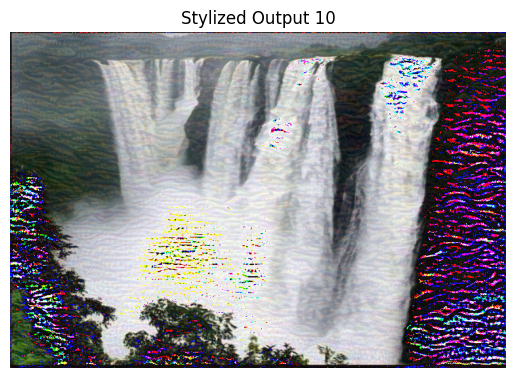

Step 0/200 | Content Loss: 0.0000, Style Loss: 0.0000
Step 50/200 | Content Loss: 5.1125, Style Loss: 0.0000
Step 100/200 | Content Loss: 5.3092, Style Loss: 0.0000
Step 150/200 | Content Loss: 5.4927, Style Loss: 0.0000


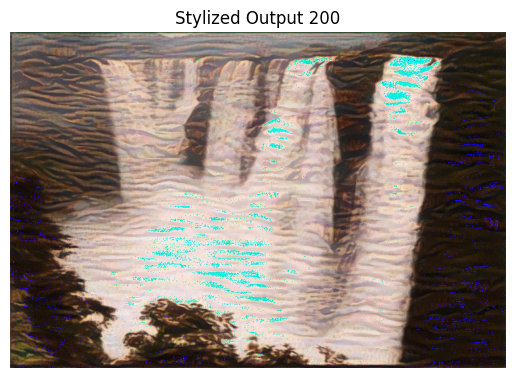

In [9]:
steps = [10, 200 ,500, 1000]
steps = [10, 200]
for i in steps:
    content_img = load_image(content_path)
    style_img = load_image(style_path)
    
    output = stylize(content_img, style_img, steps=i)
    
    # Show result
    imshow(output, f"Stylized Output {i}")

In [ ]:
# imshow(style_img, "Style")

## Fine Tuning

In [10]:
class VGGFeatures(nn.Module):
    def __init__(self, content_layers=None, style_layers=None):
        super().__init__()
        self.vgg = models.vgg19(pretrained=True).features[:29].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.content_layers = content_layers or ['21']  # e.g., relu4_2
        self.style_layers = style_layers or ['0', '5', '10', '19', '28']

    def forward(self, x):
        content_feats = {}
        style_feats = {}

        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_feats[name] = x
            if name in self.style_layers:
                style_feats[name] = x

        return content_feats, style_feats

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)
    
def compute_losses(output, content_img, style_img, extractor, style_threshold):
    output_c_feats, output_s_feats = extractor(output)
    content_feats, _ = extractor(content_img)
    _, style_feats = extractor(style_img)

    content_loss = sum(F.mse_loss(output_c_feats[l], content_feats[l]) for l in extractor.content_layers)
    
    style_loss = 0.0
    for l in extractor.style_layers:
        G_output = gram_matrix(output_s_feats[l])
        G_style = gram_matrix(style_feats[l])
        style_loss += F.mse_loss(G_output, G_style)

    total_loss = content_loss + style_threshold * style_loss
    return total_loss, content_loss, style_loss

def train_style_transfer(dataloader, extractor, steps=200, lr=0.01, style_threshold=0.8):
    results = []

    for content_img, style_img in dataloader:
        content_img = content_img.to(device)
        style_img = style_img.to(device)
        output = content_img.clone().requires_grad_(True)

        optimizer = torch.optim.LBFGS([output], lr=lr)

        def closure():
            optimizer.zero_grad()
            total_loss, content_loss, style_loss = compute_losses(output, content_img, style_img, extractor, style_threshold)
            total_loss.backward()
            return total_loss

        for _ in range(steps):
            optimizer.step(closure)

        results.append(output.detach())

    return results


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess image
def load_image(path, size=256):
    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image

# Convert tensor to displayable image
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.permute(1, 2, 0).clamp(0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Gram matrix for style representation
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

# VGG feature extractor
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features.eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.content_layers = ['21']  # relu4_2
        self.style_layers = ['0', '5', '10', '19', '28']  # relu1_1, ..., relu5_1

    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# Compute content and style loss
def compute_losses(output, content, style, extractor, style_weight):
    output_content, output_style = extractor(output)
    content_content, _ = extractor(content)
    _, style_style = extractor(style)

    content_loss = nn.functional.mse_loss(output_content['21'], content_content['21'])

    style_loss = 0
    for layer in style_style:
        G = gram_matrix(output_style[layer])
        A = gram_matrix(style_style[layer])
        style_loss += nn.functional.mse_loss(G, A)

    total_loss = content_loss + style_weight * style_loss
    return total_loss, content_loss, style_loss

# Main stylization function
def run_style_transfer(content_path, style_path, style_weight=1e5, steps=200):
    content = load_image(content_path)
    style = load_image(style_path)

    extractor = VGGFeatures()
    output = content.clone().requires_grad_(True)

    optimizer = torch.optim.LBFGS([output])

    run = [0]
    def closure():
        optimizer.zero_grad()
        total_loss, content_loss, style_loss = compute_losses(output, content, style, extractor, style_weight)
        total_loss.backward()
        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}: Content Loss = {content_loss.item():.4f}, Style Loss = {style_loss.item():.4f}")
        return total_loss

    while run[0] <= steps:
        optimizer.step(closure)

    imshow(output, title="Stylized Output")

Step 50: Content Loss = 0.1526, Style Loss = 0.0000
Step 100: Content Loss = 0.1417, Style Loss = 0.0000
Step 150: Content Loss = 0.1363, Style Loss = 0.0000
Step 200: Content Loss = 0.1337, Style Loss = 0.0000


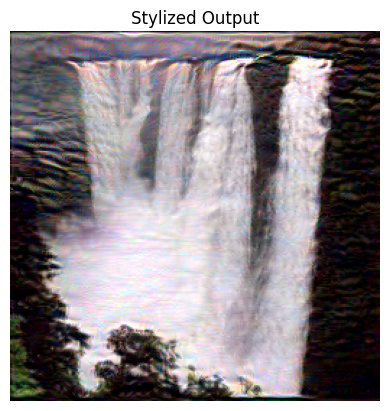

In [25]:
content_path = '/kaggle/input/image-classification/test/test/classify/2.JPG'
style_path = '/kaggle/input/wikiart/Art_Nouveau_Modern/a.y.-jackson_algoma-in-november-1935.jpg'

run_style_transfer(
    content_path,
    style_path,
    style_weight=1e9,
    steps=200
)

Step 50: Content Loss = 3.0988, Style Loss = 0.0000
Step 100: Content Loss = 3.2448, Style Loss = 0.0000
Step 150: Content Loss = 3.3063, Style Loss = 0.0000
Step 200: Content Loss = 3.3205, Style Loss = 0.0000


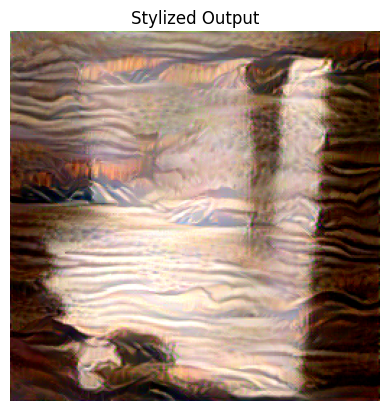

In [26]:
run_style_transfer(
    content_path,
    style_path,
    style_weight=1e9,
    steps=200
)

Step 50: Content Loss = 0.1512, Style Loss = 0.0000
Step 100: Content Loss = 0.1412, Style Loss = 0.0000
Step 150: Content Loss = 0.1373, Style Loss = 0.0000
Step 200: Content Loss = 0.1340, Style Loss = 0.0000
Step 250: Content Loss = 0.1324, Style Loss = 0.0000
Step 300: Content Loss = 0.1311, Style Loss = 0.0000
Step 350: Content Loss = 0.1305, Style Loss = 0.0000
Step 400: Content Loss = 0.1298, Style Loss = 0.0000
Step 450: Content Loss = 0.1292, Style Loss = 0.0000
Step 500: Content Loss = 0.1288, Style Loss = 0.0000


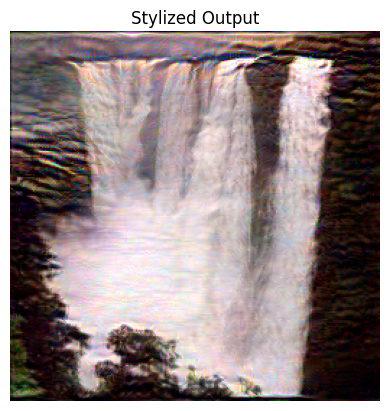

In [21]:
run_style_transfer(
    content_path,
    style_path,
    steps=500
)

## Bonus 1

Step 0: Content Loss=0.0000, Style Loss=0.0000
Step 50: Content Loss=0.0056, Style Loss=0.0000
Step 100: Content Loss=0.0020, Style Loss=0.0000
Step 150: Content Loss=0.0011, Style Loss=0.0000
Step 200: Content Loss=0.0008, Style Loss=0.0000
Step 250: Content Loss=0.0006, Style Loss=0.0000


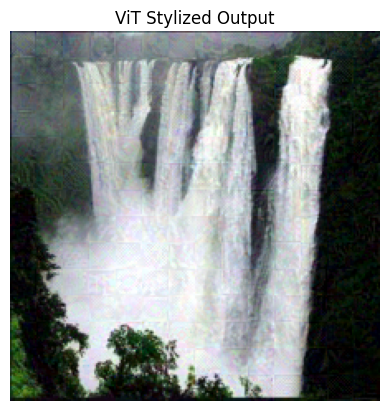

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import timm  # Pretrained ViT models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess image
def load_image(path, size=224):
    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = transform(image).unsqueeze(0).to(device)
    return image

# Convert tensor to image
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.permute(1, 2, 0).clamp(-1, 1) * 0.5 + 0.5
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Gram matrix for token features
def gram_matrix(tensor):
    B, T, D = tensor.size()  # (batch, tokens, features)
    G = torch.bmm(tensor.transpose(1, 2), tensor)  # (B, D, D)
    return G / (T * D)

# ViT Feature Extractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.model.reset_classifier(0)
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, x):
        # Extract token embeddings from transformer
        x = self.model.patch_embed(x)
        cls_token = self.model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.model.pos_embed
        x = self.model.pos_drop(x)

        for blk in self.model.blocks:
            x = blk(x)
        x = self.model.norm(x)

        return x  # Returns all tokens (including CLS)

# Compute losses using ViT features
def compute_losses(output, content, style, extractor, style_weight):
    f_out = extractor(output)
    f_content = extractor(content)
    f_style = extractor(style)

    # Content loss using CLS token
    content_loss = nn.functional.mse_loss(f_out[:, 0], f_content[:, 0])

    # Style loss using patch token embeddings (excluding CLS)
    style_loss = nn.functional.mse_loss(
        gram_matrix(f_out[:, 1:]),
        gram_matrix(f_style[:, 1:])
    )

    total_loss = content_loss + style_weight * style_loss
    return total_loss, content_loss, style_loss

# Stylization with ViT
def run_vit_style_transfer(content_path, style_path, style_weight=1e3, steps=300):
    content = load_image(content_path)
    style = load_image(style_path)
    extractor = ViTFeatureExtractor().to(device)

    output = content.clone().requires_grad_(True)
    optimizer = torch.optim.Adam([output], lr=0.01)

    for step in range(steps):
        optimizer.zero_grad()
        total_loss, c_loss, s_loss = compute_losses(output, content, style, extractor, style_weight)
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}: Content Loss={c_loss.item():.4f}, Style Loss={s_loss.item():.4f}")

    imshow(output, title="ViT Stylized Output")

# Run with example paths
run_vit_style_transfer(
    content_path,
    style_path,
    style_weight=1e3,  # less than CNN due to different scales
    steps=300
)
